In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/lstm

/content/drive/MyDrive/lstm


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from math import sqrt
from numpy import concatenate

In [4]:
# load dataset
dataset = pd.read_csv('thermal expansion error.csv', header=0, index_col=False)
dataset.drop(dataset.tail(1).index,inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [5]:
print(dataset.head())
print(dataset.tail())

    delta L         T0         T1         T2         T3         T4         T5  \
0  0.000000  25.634399  22.238941  22.898056  24.433086  23.339380  23.979705   
1  0.000000  25.504592  21.877863  22.873316  24.439756  23.335545  23.995589   
2  0.000000  25.591546  21.765013  22.864084  24.509069  23.345212  23.969459   
3  0.000000  25.361158  22.106530  22.872532  24.513056  23.338461  23.937530   
4  0.255103  25.930410  22.382248  22.945300  24.609816  23.326238  23.918648   

          T6         T7         T8         T9        T10        T11  \
0  23.616264  24.458083  23.756100  24.833099  24.720988  24.423670   
1  23.623188  24.465081  23.745714  24.831669  24.722840  24.396511   
2  23.588098  24.461532  23.739289  24.825223  24.735621  24.365926   
3  23.558015  24.465226  23.720328  24.826546  24.732799  24.370246   
4  23.551878  24.462587  23.715121  24.824342  24.732821  24.393369   

         T12        T13        T14        T15  Forward delta L  
0  28.130391  24.3007

In [6]:
## split into train and test sets 90:100
n_train = int(len(dataset) * 0.9)
train = values[:n_train, :]
test = values[n_train:, :]
print(test)
test = values[n_train:, :]
print(test)

[[13.844809 37.146706 31.214138 ... 21.70376  21.531137 13.844809]
 [13.844809 36.903427 31.463242 ... 21.690248 21.516405 13.844809]
 [13.844809 37.409924 31.58757  ... 21.692427 21.49829  13.580857]
 ...
 [13.589706 37.430824 31.775026 ... 21.784311 21.54534  13.589706]
 [13.589706 37.222473 31.700548 ... 21.786137 21.538496 13.853658]
 [13.853658 37.144833 31.34129  ... 21.788551 21.507687 13.853658]]
[[13.844809 37.146706 31.214138 ... 21.70376  21.531137 13.844809]
 [13.844809 36.903427 31.463242 ... 21.690248 21.516405 13.844809]
 [13.844809 37.409924 31.58757  ... 21.692427 21.49829  13.580857]
 ...
 [13.589706 37.430824 31.775026 ... 21.784311 21.54534  13.589706]
 [13.589706 37.222473 31.700548 ... 21.786137 21.538496 13.853658]
 [13.853658 37.144833 31.34129  ... 21.788551 21.507687 13.853658]]


In [7]:
print(train.shape)
print(test.shape)

(4213, 18)
(469, 18)


In [8]:
## normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [9]:
# split into input and outputs
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]

In [10]:
print("train_X", train_X)
print("train_y", train_y)
print("test_X", test_X)
print("test_y", test_y)

train_X [[5.0912361e-04 2.1691799e-02 4.4880867e-02 ... 1.7290115e-03
  1.3228893e-02 4.2439461e-02]
 [5.0912361e-04 1.1386871e-02 1.0686874e-02 ... 9.6058846e-04
  8.3584785e-03 4.6756268e-02]
 [5.0912361e-04 1.8289804e-02 0.0000000e+00 ... 4.2700768e-04
  6.5517426e-03 4.7125340e-02]
 ...
 [7.9706460e-01 9.4244313e-01 9.3731117e-01 ... 9.8944926e-01
  9.8112202e-01 9.1938448e-01]
 [7.9706460e-01 9.5571518e-01 9.3652606e-01 ... 9.8834372e-01
  9.7885418e-01 9.2809153e-01]
 [7.9706460e-01 9.3769693e-01 9.2538142e-01 ... 9.8668122e-01
  9.7218466e-01 9.2962933e-01]]
train_y [5.091236e-04 5.091236e-04 5.091236e-04 ... 7.970646e-01 7.970646e-01
 7.970646e-01]
test_X [[0.7970646  0.93562245 0.8948312  ... 0.98447657 0.96955204 0.92777634]
 [0.7970646  0.91630936 0.91842127 ... 0.9830663  0.96479416 0.923192  ]
 [0.7970646  0.95651865 0.93019533 ... 0.9817958  0.9655609  0.91755486]
 ...
 [0.7823874  0.9581778  0.94794726 ... 0.97601986 0.9979186  0.93219614]
 [0.7823874  0.9416375  0.94089

In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [12]:
print("train_X", train_X)
print("test_X", test_X)

train_X [[[5.0912361e-04 2.1691799e-02 4.4880867e-02 ... 1.7290115e-03
   1.3228893e-02 4.2439461e-02]]

 [[5.0912361e-04 1.1386871e-02 1.0686874e-02 ... 9.6058846e-04
   8.3584785e-03 4.6756268e-02]]

 [[5.0912361e-04 1.8289804e-02 0.0000000e+00 ... 4.2700768e-04
   6.5517426e-03 4.7125340e-02]]

 ...

 [[7.9706460e-01 9.4244313e-01 9.3731117e-01 ... 9.8944926e-01
   9.8112202e-01 9.1938448e-01]]

 [[7.9706460e-01 9.5571518e-01 9.3652606e-01 ... 9.8834372e-01
   9.7885418e-01 9.2809153e-01]]

 [[7.9706460e-01 9.3769693e-01 9.2538142e-01 ... 9.8668122e-01
   9.7218466e-01 9.2962933e-01]]]
test_X [[[0.7970646  0.93562245 0.8948312  ... 0.98447657 0.96955204 0.92777634]]

 [[0.7970646  0.91630936 0.91842127 ... 0.9830663  0.96479416 0.923192  ]]

 [[0.7970646  0.95651865 0.93019533 ... 0.9817958  0.9655609  0.91755486]]

 ...

 [[0.7823874  0.9581778  0.94794726 ... 0.97601986 0.9979186  0.93219614]]

 [[0.7823874  0.9416375  0.94089437 ... 0.97929406 0.9985614  0.9300666 ]]

 [[0.797573

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4213, 1, 17) (4213,) (469, 1, 17) (469,)


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 2501/5000
9/9 - 0s - loss: 0.0065 - val_loss: 0.0056 - 90ms/epoch - 10ms/step
Epoch 2502/5000
9/9 - 0s - loss: 0.0081 - val_loss: 0.0082 - 85ms/epoch - 9ms/step
Epoch 2503/5000
9/9 - 0s - loss: 0.0142 - val_loss: 0.0087 - 91ms/epoch - 10ms/step
Epoch 2504/5000
9/9 - 0s - loss: 0.0136 - val_loss: 0.0134 - 84ms/epoch - 9ms/step
Epoch 2505/5000
9/9 - 0s - loss: 0.0077 - val_loss: 0.0057 - 86ms/epoch - 10ms/step
Epoch 2506/5000
9/9 - 0s - loss: 0.0085 - val_loss: 0.0055 - 84ms/epoch - 9ms/step
Epoch 2507/5000
9/9 - 0s - loss: 0.0089 - val_loss: 0.0070 - 76ms/epoch - 8ms/step
Epoch 2508/5000
9/9 - 0s - loss: 0.0072 - val_loss: 0.0072 - 86ms/epoch - 10ms/step
Epoch 2509/5000
9/9 - 0s - loss: 0.0085 - val_loss: 0.0126 - 84ms/epoch - 9ms/step
Epoch 2510/5000
9/9 - 0s - loss: 0.0138 - val_loss: 0.0056 - 84ms/epoch - 9ms/step
Epoch 2511/5000
9/9 - 0s - loss: 0.0123 - val_loss: 0.0078 - 93ms/epoch - 10ms/step
Epoch 2512/5000
9/9 - 0s - loss: 0.0081 - val_loss: 0.0

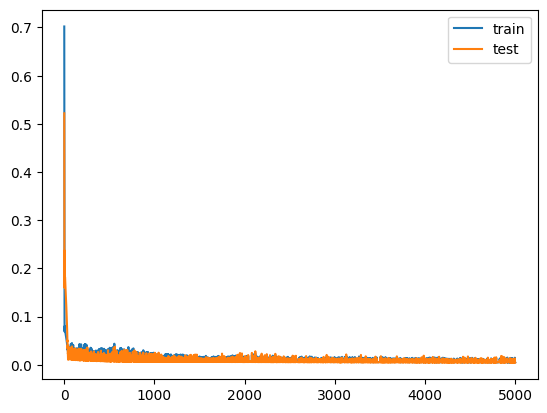

In [14]:
# def network
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=5000, batch_size=512, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
## evaluate the model and calculate Train RMSE
train_yhat = model.predict(train_X)
train_yhat_copies_array = np.repeat(train_yhat, 18, axis=-1)
inv_train_yhat = scaler.inverse_transform(np.reshape(train_yhat_copies_array, (len(train_yhat), 18)))[:, 0]
train_original_copies_array = np.repeat(train_y, 18, axis=-1)
inv_train_y = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(train_y), 18)))[:, 0]
train_rmse = sqrt(mean_squared_error(inv_train_yhat, inv_train_y))
print('Train RMSE: %.3f' % train_rmse)

132/132 [==============================] - 0s 3ms/step
Train RMSE: 0.128


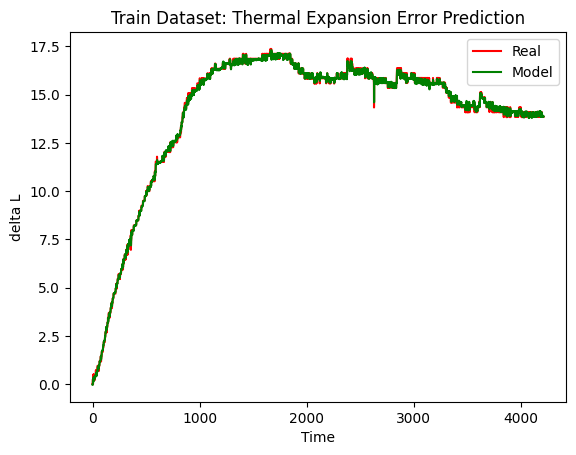

In [20]:
## plot and check
pyplot.plot(inv_train_y, color='red', label='Real')
pyplot.plot(inv_train_yhat, color='green', label='Model')
pyplot.title('Train Dataset: Thermal Expansion Error Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('delta L')
pyplot.legend()
pyplot.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
yhat_copies_array = np.repeat(yhat, 18, axis = -1)
inv_yhat = scaler.inverse_transform(np.reshape(yhat_copies_array, (len(yhat), 18)))[:, 0]


15/15 [==============================] - 0s 2ms/step


In [16]:
original_copies_array = np.repeat(test_y, 18, axis=-1)
inv_y = scaler.inverse_transform(np.reshape(original_copies_array, (len(test_y), 18)))[:, 0]

In [17]:
# calculate Test RMSE
rmse = sqrt(mean_squared_error(inv_yhat, inv_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.127


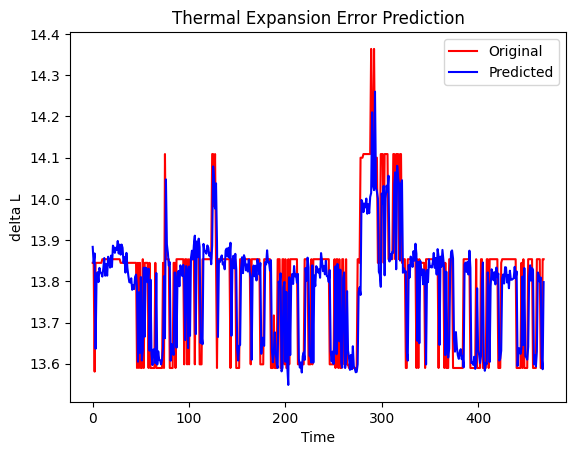

In [18]:
# plot predicted vs actual
pyplot.plot(inv_y, color='red', label='Original')
pyplot.plot(inv_yhat, color='blue', label='Predicted')
pyplot.title('Thermal Expansion Error Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('delta L')
pyplot.legend()
pyplot.show()

In [21]:
## save model
model.save('best_model.h5')